# [Computational Social Science] Project 4: Unsupervised Learning

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam, RMSprop
from keras.metrics import categorical_crossentropy
import random

For replicability, we could use the following, but they seemed a little more chaotic than they're worth.
Including for reference (can use this in practice!) 
https://stackoverflow.com/questions/32419510/how-to-get-reproducible-results-in-keras

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

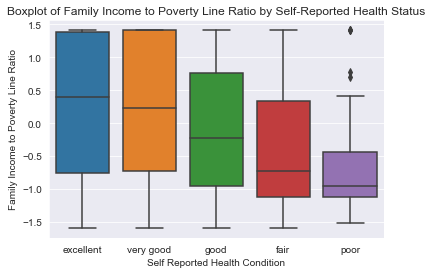

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

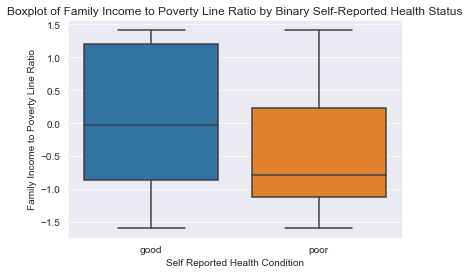

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

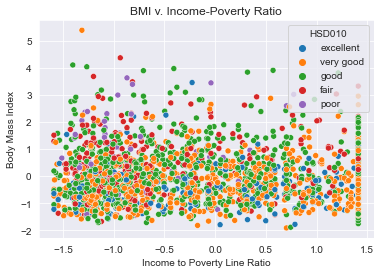

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [6]:
nhanes_scaled = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components.
- Plot a barplot of the variation explains by each component.
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

**Choice of number of components:** From what we have learned from class and lab, the first two principal components generally account for the largest possible variance/explain a large part of the dataset, with the first explaining the most variance.  Thus, we thought it made most sense to choose <i><b>two</b></i> components. (Also helps that this is what we did in lab!)

### Train PCA and Discuss Number of Components

In [7]:
#PCA on nhanes data with 2 components
from sklearn.decomposition import PCA
pca = PCA(n_components = 2)
principalComponents_nhanes = pca.fit_transform(nhanes_scaled)

In [8]:
#summarizing the 2 components

#create a dataframe of the two components
pca_df = pd.DataFrame(data = principalComponents_nhanes
             , columns = ['principal component 1', 'principal component 2',])

#see head of the dataframe
pca_df.head()

,principal component 1,principal component 2
0,9.527812,-0.816223
1,-5.838338,-3.692571
2,-0.719454,-2.573198
3,3.533626,-2.576982
4,-6.872094,-4.194238


### Barplot of Components

In [9]:
#print variance explained 
print(pca.explained_variance_ratio_)


[0.10201961 0.07623011]


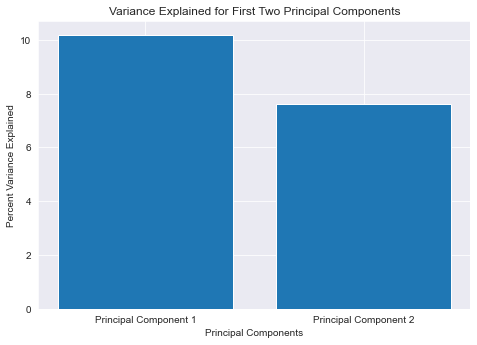

In [10]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
PrincipalComponents = ['Principal Component 1', 'Principal Component 2']
VarianceExplained = [(0.10201961*100), (0.07623011*100)]
ax.bar(PrincipalComponents, VarianceExplained)
ax.set_xlabel('Principal Components')
ax.set_ylabel('Percent Variance Explained')
ax.set_title('Variance Explained for First Two Principal Components')
plt.show()

### How many components will you use to fit a supervised learning model?

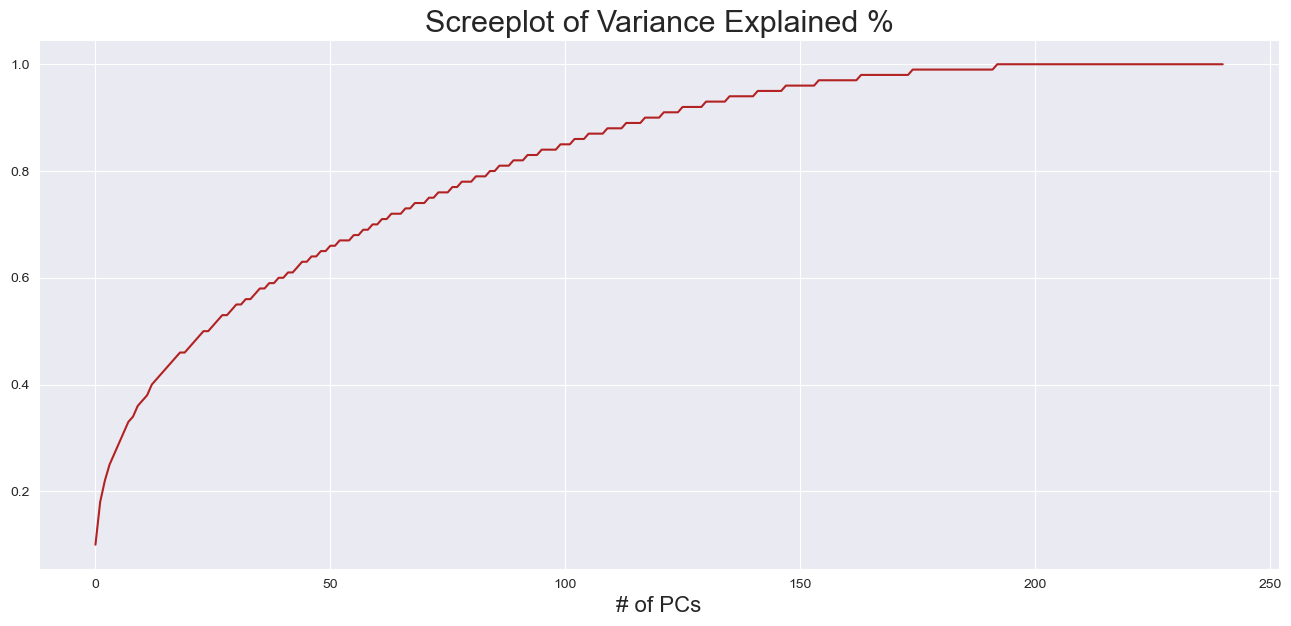

In [11]:
#Plotting variance sum to see how increasing number components for PCA affects variance explained
#May help us answer the question of how many components we will use to fit supervised model

#running PCA with no components assigned
pca2 = PCA()
principalComponents_nhanes2 = pca2.fit_transform(nhanes_scaled)

#graphing screeplot to show how many features should be kept for PCA 
#found how to do this from this website:idpproxy-ucpath.universityofcalifornia.edu
variance_exp_cumsum = pca2.explained_variance_ratio_.cumsum().round(2)
fig, axes = plt.subplots(1,1,figsize=(16,7), dpi=100)
plt.plot(variance_exp_cumsum, color='firebrick')
plt.title('Screeplot of Variance Explained %', fontsize=22)
plt.xlabel('# of PCs', fontsize=16)
plt.show()

It doesn't seem that the first two components explain much variance (~18%).  From the screeplot we plotted above, it seems that for the PCA to meaningfully capture the variance of the dataset, we would need to select ~150 or more. For simplicity, we'll only keep a few components, but we can acknowledge that this may mean that PCA won't be particularly helpful on its own! 

In [12]:
nhanes_scaled.shape

(2064, 241)

### 2D Scatterplot of the first two components

In [13]:
#add target back into the dataset
nhanes_scaledlabels=nhanes_scaled.copy() #using copy (using nhanes_scaled in future steps w/out the targets) 
nhanes_scaledlabels['HSD010_binary'] = hsd010_binary

y = pd.DataFrame(data = nhanes_scaledlabels.loc[:,['HSD010_binary']].values)

In [14]:
y.head()

,0
0,good
1,good
2,good
3,good
4,good


In [15]:
#create a dataframe of the four components
pca_df = pd.DataFrame(data = principalComponents_nhanes
             , columns = ['principal component 1', 'principal component 2'])

#see head of the dataframe
pca_df.head()

,principal component 1,principal component 2
0,9.527812,-0.816223
1,-5.838338,-3.692571
2,-0.719454,-2.573198
3,3.533626,-2.576982
4,-6.872094,-4.194238


In [16]:
#concatanate with target feature
#source of how to do this found here: https://emanuelfontelles.github.io/blog/Principal-Component-Analysis.html
finalpca_df = pd.concat([pca_df, y], axis = 1,)

#see head of data frame
finalpca_df.head(5)

,principal component 1,principal component 2,0
0,9.527812,-0.816223,good
1,-5.838338,-3.692571,good
2,-0.719454,-2.573198,good
3,3.533626,-2.576982,good
4,-6.872094,-4.194238,good


In [17]:
#name the target feature column
finalpca_df.columns = ['principal component 1', 'principal component 2', 
                       'HSD010_binary']
finalpca_df.head(5)

,principal component 1,principal component 2,HSD010_binary
0,9.527812,-0.816223,good
1,-5.838338,-3.692571,good
2,-0.719454,-2.573198,good
3,3.533626,-2.576982,good
4,-6.872094,-4.194238,good


<Figure size 432x288 with 0 Axes>

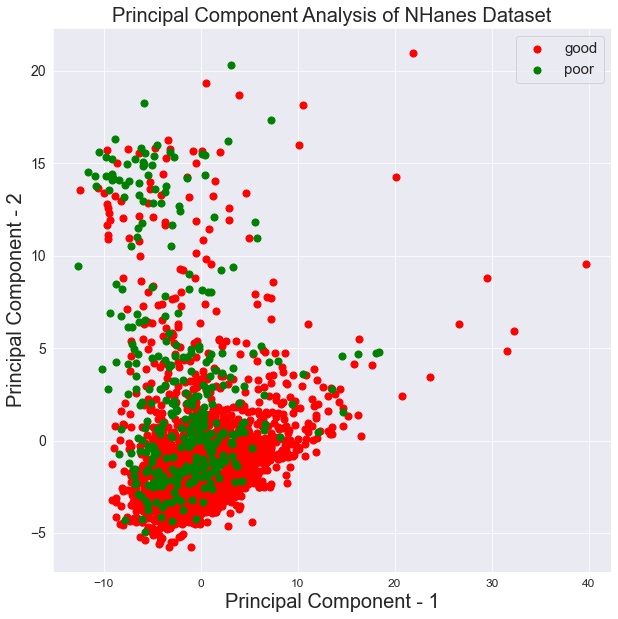

In [18]:
#scatterplot of the two components
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Principal Component Analysis of NHanes Dataset",fontsize=20)
targets = ['good', 'poor']
colors = ['r', 'g']
for target, color in zip(targets,colors):
    indicesToKeep = finalpca_df["HSD010_binary"] == target
    plt.scatter(finalpca_df.loc[indicesToKeep, 'principal component 1'], 
                finalpca_df.loc[indicesToKeep, 'principal component 2'],
                c = color, s = 50)
plt.legend(targets,prop={'size': 15})
plt.show()

I think this might be why we see the plot we see -- the two classes are not separated well, likely because together the two PCs only explain ~18% of the variance.  As shown in the screeplot, it seems that we would have to retain many features in order for our PCA to capture most of the information from our original dataset.  Not sure this is the best method for this dataset!

We will still stick with using two principal components only. In order to get about 90% of the variation explained, we would need about 125 principal components. While this is still better than 241, this is still pretty substantial, so at that point, we might as well stick with the 241 and keep the ability to interpret our features better. Therefore, we'll stick with two principal components, which is common, though noting that it's certainly not informative and may not perform quite well here (at least on its own!) 

## Clustering

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

For our clustering algorithm, we will use the Density-Based Spatial Clustering of Applications with Noise (DBSCAN) algorithm. Unlike K-means, we do not need to select the numbers of clusters beforehand. DBSCAN also works well to identify odd patterns (which it appears we may have here) and classify outliers as noise. 

### Cluster nhanes

In [19]:
# import model object
from sklearn.cluster import DBSCAN

# define model object
dbscan = DBSCAN(eps=.5) #Using the default epsilon for both runs - nhanes_scaled and PCA data

# fit model to data 
dbscan.fit(nhanes);

In [20]:
# get fitted labels for each data point 
labels = dbscan.labels_
labels

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [21]:
len(set(labels)) 

1

Check if there any outliers not included in either cluster (indicated with a `-1`).

In [22]:
# get inferred clusters
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

0

In [23]:
dbscan.labels_

array([-1, -1, -1, ..., -1, -1, -1], dtype=int64)

In [24]:
## Let's create the dataset for our plot! ## 
nhanes_scaledlabels_originalcluster=nhanes_scaled.copy()
nhanes_scaledlabels_originalcluster['cluster_labels']=dbscan.labels_

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

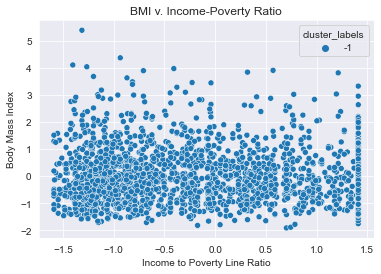

In [25]:
# plot data with cluster assignment as the color 
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "cluster_labels", palette = "tab10", data = nhanes_scaledlabels_originalcluster)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Note, while this is not included in the above code, we tested out multiple values of epsilon to see how this changed results. It was determined that epsilon has to be really large in order for us to get more than one cluster. We will use the same value of epsilon (0.5) for the DBSCAN clustering on our PCA'd data to see if our clustering performs better there. Currently, this is wildly uninformative! Hopefully that will not be the case with the PCA data! 

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

In [26]:
# fit model to data 
dbscan.fit(pca_df);

In [27]:
# get fitted labels for each data point 
labels = dbscan.labels_
labels

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [28]:
len(set(labels)) 

15

In [29]:
# get inferred clusters
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_

14

In [30]:
dbscan.labels_

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [31]:
## Let's create the dataset for our plot! ## 
nhanes_scaledlabels_pcacluster=finalpca_df
nhanes_scaledlabels_pcacluster['cluster_labels']=dbscan.labels_

In [32]:
nhanes_scaledlabels_pcacluster.head(5)

,principal component 1,principal component 2,HSD010_binary,cluster_labels
0,9.527812,-0.816223,good,0
1,-5.838338,-3.692571,good,0
2,-0.719454,-2.573198,good,0
3,3.533626,-2.576982,good,0
4,-6.872094,-4.194238,good,0


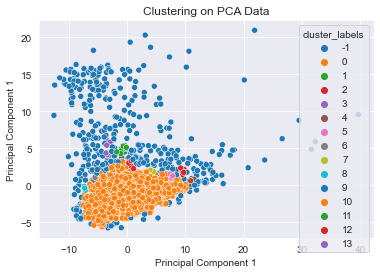

In [33]:
# plot data with cluster assignment as the color 
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax = sns.scatterplot(x = "principal component 1", y = "principal component 2", hue = "cluster_labels", palette = "tab10", data = nhanes_scaledlabels_pcacluster)
ax.set(xlabel = "Principal Component 1",
      ylabel = "Principal Component 1")
ax.set_title("Clustering on PCA Data")
plt.show()

That looks much better on the PCA! Way to be, DBSCAN + PCA! The clusters appear to do pretty well at separating out different groups of observations, with a few clusters containing many observations, and small pockets of clusters dispersed throughout our 2-dimensional space, though notably, even these smaller clusters seem to identify a close, small group of observations well (i.e., they are not dispersed widely throughout the 2D space.)

While it's doing a good job identifying similar groups of observations, this doesn't mean that these groups will coincide with our target! 

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [34]:
HSD010_Binary= hsd010_binary.replace(to_replace=['good', 'poor'], value=[1, 0])
print(HSD010_Binary)

SEQN
73568    1
73576    1
73579    1
73581    1
73584    1
        ..
83694    1
83696    1
83704    0
83716    1
83721    1
Name: HSD010, Length: 2064, dtype: int64


In [35]:
y = HSD010_Binary # either hsd010 or hsd010_binary
X = nhanes_scaled # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [36]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [37]:
num_classes = 10
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [38]:
model = Sequential()

model.add(
    Dense(32, input_dim = 241, kernel_initializer ='normal', activation ='relu')
)

model.add(
    Dense(num_classes, kernel_initializer ='normal', activation ='softmax')
)

## Add any additional layers you wish here

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10, batch_size = 200, verbose = 2)

Epoch 1/10
8/8 - 0s - loss: 2.1916 - accuracy: 0.2532 - val_loss: 2.0848 - val_accuracy: 0.4341
Epoch 2/10
8/8 - 0s - loss: 1.9719 - accuracy: 0.5620 - val_loss: 1.8676 - val_accuracy: 0.6221
Epoch 3/10
8/8 - 0s - loss: 1.7321 - accuracy: 0.6841 - val_loss: 1.6205 - val_accuracy: 0.7016
Epoch 4/10
8/8 - 0s - loss: 1.4624 - accuracy: 0.7494 - val_loss: 1.3457 - val_accuracy: 0.7636
Epoch 5/10
8/8 - 0s - loss: 1.1798 - accuracy: 0.8004 - val_loss: 1.0659 - val_accuracy: 0.7888
Epoch 6/10
8/8 - 0s - loss: 0.9153 - accuracy: 0.8230 - val_loss: 0.8254 - val_accuracy: 0.8217
Epoch 7/10
8/8 - 0s - loss: 0.7069 - accuracy: 0.8417 - val_loss: 0.6556 - val_accuracy: 0.8391
Epoch 8/10
8/8 - 0s - loss: 0.5724 - accuracy: 0.8508 - val_loss: 0.5542 - val_accuracy: 0.8469
Epoch 9/10
8/8 - 0s - loss: 0.4925 - accuracy: 0.8585 - val_loss: 0.4971 - val_accuracy: 0.8527
Epoch 10/10
8/8 - 0s - loss: 0.4448 - accuracy: 0.8682 - val_loss: 0.4625 - val_accuracy: 0.8566


### Neural Network on Principal Components

In [39]:
y = HSD010_Binary # either hsd010 or hsd010_binary
X = finalpca_df.drop(['HSD010_binary'], axis = 1) # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [40]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [41]:
num_classes = 10
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [42]:
model = Sequential()

model.add(
    Dense(32, input_dim = 3, kernel_initializer ='normal', activation ='relu')
)

model.add(
    Dense(num_classes, kernel_initializer ='normal', activation ='softmax')
)

## Add any additional layers you wish here

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10, batch_size = 200, verbose = 2)

Epoch 1/10
8/8 - 0s - loss: 2.2724 - accuracy: 0.2274 - val_loss: 2.2323 - val_accuracy: 0.4050
Epoch 2/10
8/8 - 0s - loss: 2.1942 - accuracy: 0.6027 - val_loss: 2.1563 - val_accuracy: 0.8295
Epoch 3/10
8/8 - 0s - loss: 2.1118 - accuracy: 0.8262 - val_loss: 2.0730 - val_accuracy: 0.8391
Epoch 4/10
8/8 - 0s - loss: 2.0198 - accuracy: 0.8391 - val_loss: 1.9790 - val_accuracy: 0.8353
Epoch 5/10
8/8 - 0s - loss: 1.9169 - accuracy: 0.8346 - val_loss: 1.8717 - val_accuracy: 0.8275
Epoch 6/10
8/8 - 0s - loss: 1.8000 - accuracy: 0.8314 - val_loss: 1.7529 - val_accuracy: 0.8217
Epoch 7/10
8/8 - 0s - loss: 1.6735 - accuracy: 0.8301 - val_loss: 1.6238 - val_accuracy: 0.8217
Epoch 8/10
8/8 - 0s - loss: 1.5400 - accuracy: 0.8346 - val_loss: 1.4882 - val_accuracy: 0.8217
Epoch 9/10
8/8 - 0s - loss: 1.4034 - accuracy: 0.8359 - val_loss: 1.3512 - val_accuracy: 0.8275
Epoch 10/10
8/8 - 0s - loss: 1.2691 - accuracy: 0.8385 - val_loss: 1.2171 - val_accuracy: 0.8275


### Neural Network on Principal Components + Cluster Membership

In [43]:
y = HSD010_Binary # either hsd010 or hsd010_binary
X = nhanes_scaledlabels_pcacluster.drop(['HSD010_binary'], axis = 1) # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .25, random_state = 10)

In [44]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

In [45]:
num_classes = 10
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [46]:
model = Sequential()

model.add(
    Dense(32, input_dim = 3, kernel_initializer ='normal', activation ='relu')
)

model.add(
    Dense(num_classes, kernel_initializer ='normal', activation ='softmax')
)

## Add any additional layers you wish here

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10, batch_size = 200, verbose = 2)

Epoch 1/10
8/8 - 0s - loss: 2.2725 - accuracy: 0.3269 - val_loss: 2.2292 - val_accuracy: 0.6182
Epoch 2/10
8/8 - 0s - loss: 2.1929 - accuracy: 0.7035 - val_loss: 2.1527 - val_accuracy: 0.7868
Epoch 3/10
8/8 - 0s - loss: 2.1112 - accuracy: 0.7926 - val_loss: 2.0707 - val_accuracy: 0.8023
Epoch 4/10
8/8 - 0s - loss: 2.0230 - accuracy: 0.8088 - val_loss: 1.9792 - val_accuracy: 0.8081
Epoch 5/10
8/8 - 0s - loss: 1.9244 - accuracy: 0.8127 - val_loss: 1.8764 - val_accuracy: 0.8140
Epoch 6/10
8/8 - 0s - loss: 1.8151 - accuracy: 0.8211 - val_loss: 1.7628 - val_accuracy: 0.8140
Epoch 7/10
8/8 - 0s - loss: 1.6963 - accuracy: 0.8256 - val_loss: 1.6398 - val_accuracy: 0.8159
Epoch 8/10
8/8 - 0s - loss: 1.5701 - accuracy: 0.8301 - val_loss: 1.5099 - val_accuracy: 0.8198
Epoch 9/10
8/8 - 0s - loss: 1.4393 - accuracy: 0.8301 - val_loss: 1.3774 - val_accuracy: 0.8236
Epoch 10/10
8/8 - 0s - loss: 1.3090 - accuracy: 0.8262 - val_loss: 1.2458 - val_accuracy: 0.8256


#### Explanation of Results ####
So our PCA and PCA + Clustering neural networks really didn't perform better (often, it performed worse). After getting feedback from Aniket (thank you!), this makes sense. We definitely knew our PCA alone would not perform particularly well, since our PCA data with good/poor health plot demonstrated that our components were not very informative of health status. Similarly, while the PCA + Clustering was helpful at identifying similar groups, these groups are also not particularly informative of health status (good/poor). Therefore, there's really no benefit to using these methods as we specified them in this case (using our original dataset is fine). We could of course do hyperparameter tuning (see below) or we could alternatively specify a greater number of principal components, but the former is computationally intensive (so something we should apply in practice but won't include here for the sake of time and because 2020), and the latter probably won't make a substantial difference here.  

If we wanted to, we could also do some hyperparameter tuning here. Following from the source below, we could run hypertune on elements like the number of filters or the activation function. Thanks also to Aniket for the help and feedback here; this saved us lots of time! :) 

https://www.sicara.ai/blog/hyperparameter-tuning-keras-tuner


## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA is a method that allows us to summarize a set of features with a smaller number of representative features to explain most of the variability in the original set of features, while clustering works to discover groupings of similar features within the data.  PCA can reduce the size of our dataset through utilizing a smaller number of components as our features, while it seems clustering is more focused on identifying highly similar groups amongst the datapoints themselves.  

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

Yes, we think we did see some advantages.  It seems that running the PCA helps to better establish the clusters -- you’re doing it on a smaller set of features and so maybe it’s that it is computationally easier for clusters to be recognized than if clustering was run on the whole original dataset (less noise, better performing algorithms). 

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

Unsupervised techniques help with exploratory data analysis -- helping us learn more about the patterns or characteristics of our X features.  This can be useful in finding a representative set of features. For example, PCA can help us find a decomposed set of features that can explain the same amount of variability as a much larger set of features, which saves us computational time and power in downstream supervised learning tasks. 

Unsupervised techniques also help uncover patterns that may be useful in thinking of unique research questions that require supervised learning tasks. The techniques may help us focus in on specific features that might be more important to predicting an outcome of interest and help us visualize high-dimensional data easily, for example (Kavyazin, 2019).* 

In working with “big data” it may also be timely or even impossible to label large datasets, so unsupervised learning techniques can be useful in these cases.

*Source: https://medium.com/@dmitriy.kavyazin/principal-component-analysis-and-k-means-clustering-to-visualize-a-high-dimensional-dataset-577b2a7a5fe2 